In [97]:
import json
import pandas as pd

import networkx as nx, numpy as np
from dowhy import gcm

# plus tqdm, typing_extensions, matplotlib

In [98]:
# notice thousands - profiler node uses millisecond timestamps
def get_throughput_from_trace_data(filename, aggregation_period=10_000):
    # this function reads trace.log and aggregates data by periods of given length for each node
    # the output is a dataframe where each row corresponds to a new period
    # columns - to nodes in the flow
    # and value in the cell is throughput - how many messages went through a given node in a given period
    with open(filename, 'r') as trace_file:
        trace_lines = trace_file.readlines()

    trace_data = []
    for trace_line in trace_lines:
        trace = json.loads(trace_line)
        trace_data.append(trace)

    node_output_times = {}
    for trace in trace_data:
        # why -18?
        # because we don't want to look at all the loops auto-play is doing
        # and only want to see the profile of the message once it went to display
        # this turned out to be reflected in 18 last entries in "trace"
        # everything before is just loops, more of them for each message
        onSendEvents = [event for event in trace["trace"][-18:] if event['eventName'] == 'onSend']
        for event in onSendEvents:
            node_id = event['node']['id']
            timestamp = event['timestamp']
            if node_id not in node_output_times:
                node_output_times[node_id] = []
            node_output_times[node_id].append(timestamp)
    
    start_timestamp = min(min(t) for t in node_output_times.values())
    stop_timestamp = max(max(t) for t in node_output_times.values())

    periods = []
    t = start_timestamp
    while t+aggregation_period < stop_timestamp:
        periods.append((t, t+aggregation_period))
        t += aggregation_period

    # iterate one more time just to get all nodes in a list
    onSendEvents = [event for event in trace_data[0]["trace"][-18:] if event['eventName'] == 'onSend']
    nodes = [event['node'] for event in onSendEvents]

    throughputs = {}
    for node in nodes:
        throughputs[node['id']] = []
        output_times = node_output_times[node['id']]
        for period in periods:
            count = len([x for x in output_times if period[0] <= x and x < period[1]])
            throughputs[node['id']].append(count)

    df = pd.DataFrame(throughputs)

    return df, nodes

In [104]:
df_before_1, nodes = get_throughput_from_trace_data("trace_before_1.log", aggregation_period=5_000)
df_before_2, _ = get_throughput_from_trace_data("trace_before_2.log", aggregation_period=5_000)
df_before_3, _ = get_throughput_from_trace_data("trace_before_3.log", aggregation_period=5_000)
df_buildDelay_1, _ = get_throughput_from_trace_data("trace_buildDelay_1.log", aggregation_period=5_000)
df_buildDelay_2, _ = get_throughput_from_trace_data("trace_buildDelay_2.log", aggregation_period=5_000)
df_buildDelay_3, _ = get_throughput_from_trace_data("trace_buildDelay_3.log", aggregation_period=5_000)
df_bothDelay_1, _ = get_throughput_from_trace_data("trace_bothDelay_1.log", aggregation_period=5_000)
df_bothDelay_2, _ = get_throughput_from_trace_data("trace_bothDelay_2.log", aggregation_period=5_000)
df_bothDelay_3, _ = get_throughput_from_trace_data("trace_bothDelay_3.log", aggregation_period=5_000)

<AxesSubplot: ylabel='Frequency'>

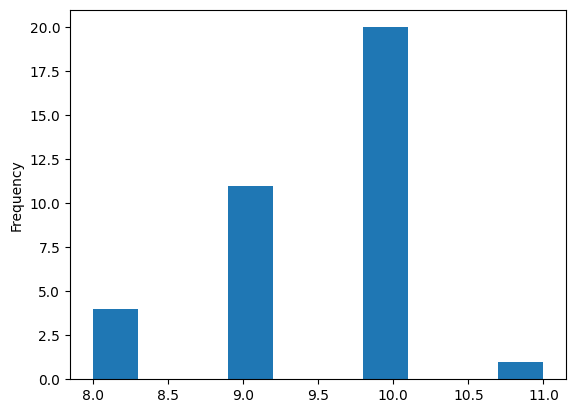

In [114]:
df_before['7db5d25abf49b78e'].plot.hist()

<AxesSubplot: ylabel='Frequency'>

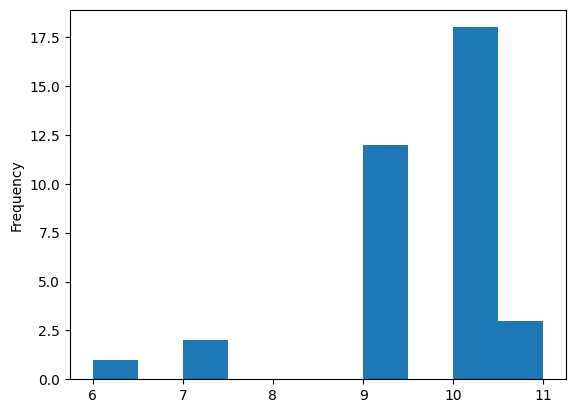

In [116]:
df_buildDelay['7db5d25abf49b78e'].plot.hist()

<AxesSubplot: ylabel='Frequency'>

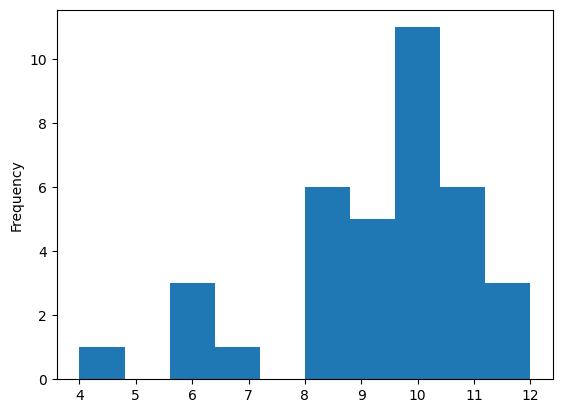

In [117]:
df_bothDelay['7db5d25abf49b78e'].plot.hist()

In [115]:
df_before = pd.concat([df_before_1, df_before_2, df_before_3])
df_buildDelay = pd.concat([df_buildDelay_1, df_buildDelay_2, df_buildDelay_3])
df_bothDelay = pd.concat([df_bothDelay_1, df_bothDelay_2, df_bothDelay_3])

In [106]:
nodes_ids = [node['id'] for node in nodes]
causal_graph = nx.DiGraph(zip(nodes_ids[:-1], nodes_ids[1:]))
causal_model = gcm.ProbabilisticCausalModel(causal_graph)
causal_model.set_causal_mechanism(nodes_ids[0], gcm.EmpiricalDistribution())
for node_id in nodes_ids[1:]:
    causal_model.set_causal_mechanism(node_id, gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

In [107]:
attributions = gcm.distribution_change(causal_model, df_before, df_buildDelay, nodes[-1]['id'])

/home/ubuntu/projects/causality-fbp/.venv/lib/python3.10/site-packages/dowhy/gcm/distribution_change.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_data = old_data.append(new_data, ignore_index=True, sort=True)
Estimating Shapley Values. Average change of Shapley values in run 4 (20 evaluated permutations): -2.5411365410651343%: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


In [108]:
attributions

{'2f380911.38291e': 4.079130726392016,
 '7db5d25abf49b78e': -0.030029111584481606,
 'c312a0c.eef3ce': -0.06409438922247779,
 'c5161aa1.85248': -0.09074238690634004,
 'da968efe.e1f1f': 0.2124023931298046,
 'deb9e3943de84f28': 0.14410074067092407,
 'e3acce5d13799473': -0.0431717157107326,
 'f50cf07b.26f8': 0.11368760608001718,
 'f6f5bcbd.ad6ca': 0.07288968921906307}

In [109]:
nodes

[{'id': 'c5161aa1.85248', 'name': 'AutoPlay', 'type': 'switch'},
 {'id': 'f6f5bcbd.ad6ca', 'name': 'Next Block', 'type': 'function'},
 {'id': 'c312a0c.eef3ce',
  'name': 'Next block of sensor data',
  'type': 'function'},
 {'id': 'f50cf07b.26f8', 'name': 'Set filename', 'type': 'change'},
 {'id': 'deb9e3943de84f28',
  'name': 'Additional random delay',
  'type': 'delay'},
 {'id': 'da968efe.e1f1f', 'name': 'Get OpenEEW data', 'type': 'http request'},
 {'id': '2f380911.38291e', 'name': 'Build Quake Charts', 'type': 'function'},
 {'id': 'e3acce5d13799473', 'name': 'Detect earthquake', 'type': 'function'},
 {'id': '7db5d25abf49b78e', 'name': 'Retrieve trace data', 'type': 'function'}]

In [110]:
attributions = gcm.distribution_change(causal_model, df_before, df_bothDelay, nodes[-1]['id'])

/home/ubuntu/projects/causality-fbp/.venv/lib/python3.10/site-packages/dowhy/gcm/distribution_change.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_data = old_data.append(new_data, ignore_index=True, sort=True)
Estimating Shapley Values. Average change of Shapley values in run 3 (15 evaluated permutations): -42.71772035743764%: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


In [111]:
attributions

{'2f380911.38291e': 1.0986342886662277,
 '7db5d25abf49b78e': -0.001273319302248995,
 'c312a0c.eef3ce': 0.06098387266253561,
 'c5161aa1.85248': -0.11484934359024644,
 'da968efe.e1f1f': 0.05065947561538618,
 'deb9e3943de84f28': 0.5924365526794292,
 'e3acce5d13799473': -0.06615202520647846,
 'f50cf07b.26f8': -0.010736508064763606,
 'f6f5bcbd.ad6ca': -0.0633437897120527}